In [2]:
!pip install csbdeep
!pip install spectral
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
import spectral.io.envi as envi
from spectral import *

     |████████████████████████████████| 71kB 2.5MB/s 
     |████████████████████████████████| 133kB 8.7MB/s 
     |████████████████████████████████| 18.1MB 198kB/s 
     |████████████████████████████████| 194kB 3.4MB/s 
TensorFlow 1.x selected.
1.15.2


In [3]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from csbdeep.utils import plot_some
from csbdeep.io import load_training_data
from csbdeep.models import CARE

Using TensorFlow backend.


You can use function below to load parameters for image prediction.
Supported models: 18-23



In [0]:
import pandas as pd
def load_parameters(model_number, path_to_params):
  try:
    params = pd.read_pickle(path_to_params)
  except:
    print('File not found')
  if np.any(params.loc[:, 'model_number'] == model_number):
    factor = float(params.loc[params.loc[:, 'model_number'] == model_number]['factor'])
    clip = int(params.loc[params.loc[:, 'model_number'] == model_number]['clip'])
    return factor, clip
  print('No parameters found')

In [ ]:
import os
base_path = os.path.abspath('')

In [5]:
path_to_params = base_path + '/Data/parameters_for_restoration.pkl'
model_number = 23
factor, clip = load_parameters(model_number, path_to_params)
print(factor, clip)

800.0 2000


In [0]:
from keras import backend as K
from keras.layers import Activation
def relu_advanced(x):
    return K.relu(x, max_value=63 * factor)

def internal_activation(x):
  return K.relu(x, max_value=None)

from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'linear': Activation(relu_advanced)})
get_custom_objects().update({'relu': Activation(internal_activation)})

In [7]:
!nvidia-smi

Wed Apr 29 08:04:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
img = envi.open(base_path + '/Data/SVDNB_npp_20160101-20161231_global_vcm-ntl.avg_rade9_resampled.hdr', base_path + '/Data/SVDNB_npp_20160101-20161231_global_vcm-ntl.avg_rade9_resampled')
img_new = img.load()
img_new = np.clip(img_new, 0, clip)

In [9]:
img_new = img_new.reshape(1, 16801, 43201)
img_new.shape

(1, 16801, 43201)

In [10]:
model = CARE(config=None, name='my_model_long_{}'.format(model_number), basedir=base_path + '/models')
axes = 'CYX'

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Loading network weights from 'weights_best.h5'.


In [11]:
restored = model.predict(img_new, axes, n_tiles=(1, 15, 15), normalizer=None)

100%|██████████| 225/225 [14:11<00:00,  3.79s/it]


In [12]:
print(np.max(restored), np.min(restored))

50400.0 0.0


In [0]:
from skimage.io import imsave
from skimage.io import call_plugin, use_plugin, find_available_plugins

In [14]:
find_available_plugins(True)

{'imageio': ['imread', 'imsave', 'imread_collection'],
 'matplotlib': ['imshow', 'imread', 'imshow_collection', 'imread_collection']}

In [0]:
restored_processed = restored.reshape(16801, 43201)
restored_processed = restored_processed / factor
restored = None

In [16]:
np.around(restored_processed, 0, out=restored_processed)
restored_processed = restored_processed.astype('float32', copy=False)
np.max(restored_processed)

63.0

In [0]:
use_plugin('imageio')

In [18]:
imsave(base_path + '/Predictions/pred{}.jpg'.format(model_number), restored_processed, quality=75)
np.savez(base_path + '/Predictions/pred{}.npz'.format(model_number), restored_processed)

ImageView object:
  Display bands       :  [0]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 63.0]
    G: [0.0, 63.0]
    B: [0.0, 63.0]

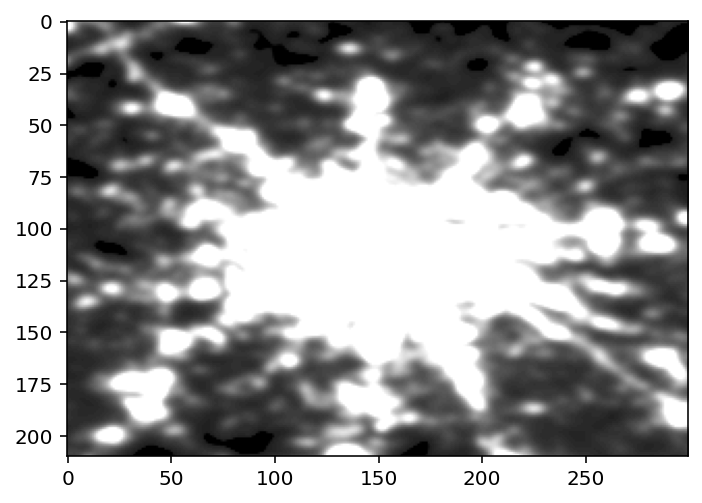

In [20]:
i = 2410
j = 26256
imshow(restored_processed[i-210:i, j-300: j])